<a href="https://colab.research.google.com/github/meysam-kazemi/drive-unet/blob/main/fr_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd drive/MyDrive/RETINAL/

In [ ]:
%ls

augment.ipynb  files/         models/    outputs/  test.zip   training_pro/  unet-2.ipynb
datasets/      fr-unet.ipynb  new_data/  test/     training/  training.zip   unet.ipynb


In [ ]:

CFG = {
    'model':{'type': 'FR_UNet'},
    'loss':{'type': 'BCELoss'},
    'optimizer':{'type': 'Adam','args':{'lr': 1e-4,'weight_decay': 1e-5}},
    'lr_scheduler':{'type': 'CosineAnnealingLR','args':{'T_max': 40}},
    'epochs':100,
    'save_dir': 'saved/',
    'val_per_epochs': 1,
    'save_period': 5,
    'tensorboard': True,
    'threshold': 0.5,
    'threshold_low': 0.3,
    'DTI': False,
    'amp': True,
    'tta': False,
    'CCC': False,
    }

# UTILS

In [ ]:
# helpers
import os
import pickle
import random
import cv2
import numpy as np
import torch
from torchvision.transforms import functional as F


def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


class Fix_RandomRotation(object):

    def __init__(self, degrees=360, resample=False, expand=False, center=None):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params():
        p = torch.rand(1)

        if p >= 0 and p < 0.25:
            angle = -180
        elif p >= 0.25 and p < 0.5:
            angle = -90
        elif p >= 0.5 and p < 0.75:
            angle = 90
        else:
            angle = 0
        return angle

    def __call__(self, img):
        angle = self.get_params()
        return F.rotate(img, angle, self.resample, self.expand, self.center)

    def __repr__(self):
        format_string = self.__class__.__name__ + \
            '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string


def dir_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)


def remove_files(path):
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))


def read_pickle(path, type):
    with open(file=path + f"/{type}.pkl", mode='rb') as file:
        img = pickle.load(file)
    return img


def save_pickle(path, type, img_list):
    with open(file=path + f"/{type}.pkl", mode='wb') as file:
        pickle.dump(img_list, file)


def double_threshold_iteration(index,img, h_thresh, l_thresh, save=True):
    h, w = img.shape
    img = np.array(torch.sigmoid(img).cpu().detach()*255, dtype=np.uint8)
    bin = np.where(img >= h_thresh*255, 255, 0).astype(np.uint8)
    gbin = bin.copy()
    gbin_pre = gbin-1
    while(gbin_pre.all() != gbin.all()):
        gbin_pre = gbin
        for i in range(h):
            for j in range(w):
                if gbin[i][j] == 0 and img[i][j] < h_thresh*255 and img[i][j] >= l_thresh*255:
                    if gbin[i-1][j-1] or gbin[i-1][j] or gbin[i-1][j+1] or gbin[i][j-1] or gbin[i][j+1] or gbin[i+1][j-1] or gbin[i+1][j] or gbin[i+1][j+1]:
                        gbin[i][j] = 255

    if save:
        cv2.imwrite(f"save_picture/bin{index}.png", bin)
        cv2.imwrite(f"save_picture/gbin{index}.png", gbin)
    return gbin/255


def recompone_overlap(preds, img_h, img_w, stride_h, stride_w):
    assert (len(preds.shape) == 4)
    assert (preds.shape[1] == 1 or preds.shape[1] == 3)
    patch_h = preds.shape[2]
    patch_w = preds.shape[3]
    N_patches_h = (img_h - patch_h) // stride_h + 1
    N_patches_w = (img_w - patch_w) // stride_w + 1
    N_patches_img = N_patches_h * N_patches_w
    assert (preds.shape[0] % N_patches_img == 0)
    N_full_imgs = preds.shape[0] // N_patches_img
    full_prob = np.zeros((N_full_imgs, preds.shape[1], img_h, img_w))
    full_sum = np.zeros((N_full_imgs, preds.shape[1], img_h, img_w))
    k = 0
    for i in range(N_full_imgs):
        for h in range((img_h - patch_h) // stride_h + 1):
            for w in range((img_w - patch_w) // stride_w + 1):
                full_prob[i, :, h * stride_h:(h * stride_h) + patch_h, w * stride_w:(w * stride_w) + patch_w] += preds[
                    k]
                full_sum[i, :, h * stride_h:(h * stride_h) + patch_h,
                         w * stride_w:(w * stride_w) + patch_w] += 1
                k += 1
    assert (k == preds.shape[0])
    assert (np.min(full_sum) >= 1.0)
    final_avg = full_prob / full_sum
    return final_avg

In [ ]:
# losses

import torch
import torch.nn as nn


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.CE_loss = nn.CrossEntropyLoss(
            reduction=reduction, ignore_index=ignore_index, weight=alpha)

    def forward(self, output, target):
        logpt = self.CE_loss(output, target)
        pt = torch.exp(-logpt)
        loss = ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        return loss.sum()


class BCELoss(nn.Module):
    def __init__(self, reduction="mean", pos_weight=1.0):
        pos_weight = torch.tensor(pos_weight).cuda()
        super(BCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(
            reduction=reduction, pos_weight=pos_weight)

    def forward(self, prediction, targets):
        return self.bce_loss(prediction, targets)


class CELoss(nn.Module):
    def __init__(self, weight=[1, 1], ignore_index=-100, reduction='mean'):
        super(CELoss, self).__init__()
        weight = torch.tensor(weight).cuda()
        self.CE = nn.CrossEntropyLoss(
            weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target.squeeze(1).long())
        return loss


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)
        intersection = 2 * torch.sum(prediction * target) + self.smooth
        union = torch.sum(prediction) + torch.sum(target) + self.smooth
        loss = 1 - intersection / union
        return loss


class CE_DiceLoss(nn.Module):
    def __init__(self, reduction="mean", D_weight=0.5):
        super(CE_DiceLoss, self).__init__()
        self.DiceLoss = DiceLoss()
        self.BCELoss = BCELoss(reduction=reduction)
        self.D_weight = D_weight

    def forward(self, prediction, targets):
        return self.D_weight * self.DiceLoss(prediction, targets) + (1 - self.D_weight) * self.BCELoss(prediction,
                                                                                                       targets)

## metrics

In [ ]:
import numpy as np
import torch
import cv2
from sklearn.metrics import roc_auc_score


class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = np.multiply(val, weight)
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum = np.add(self.sum, np.multiply(val, weight))
        self.count = self.count + weight
        self.avg = self.sum / self.count

    @property
    def value(self):
        return np.round(self.val, 4)

    @property
    def average(self):
        return np.round(self.avg, 4)


def get_metrics(predict, target, threshold=None, predict_b=None):
    predict = torch.sigmoid(predict).cpu().detach().numpy().flatten()
    if predict_b is not None:
        predict_b = predict_b.flatten()
    else:
        predict_b = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy().flatten()
    else:
        target = target.flatten()
    tp = (predict_b * target).sum()
    tn = ((1 - predict_b) * (1 - target)).sum()
    fp = ((1 - target) * predict_b).sum()
    fn = ((1 - predict_b) * target).sum()
    auc = roc_auc_score(target>0.5, predict)
    acc = (tp + tn) / (tp + fp + fn + tn)
    pre = tp / (tp + fp)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    iou = tp / (tp + fp + fn)
    f1 = 2 * pre * sen / (pre + sen)
    return {
        "AUC": np.round(auc, 4),
        "F1": np.round(f1, 4),
        "Acc": np.round(acc, 4),
        "Sen": np.round(sen, 4),
        "Spe": np.round(spe, 4),
        "pre": np.round(pre, 4),
        "IOU": np.round(iou, 4),
    }


def count_connect_component(predict, target, threshold=None, connectivity=8):
    if threshold != None:
        predict = torch.sigmoid(predict).cpu().detach().numpy()
        predict = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy()
    pre_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        predict, dtype=np.uint8)*255, connectivity=connectivity)
    gt_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        target, dtype=np.uint8)*255, connectivity=connectivity)
    return pre_n/gt_n

# Models

## utils

In [ ]:
%pip install timm

In [ ]:
from torch import nn
from timm.models.layers import trunc_normal_

class InitWeights_He(object):
    def __init__(self, neg_slope=1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        if isinstance(module, nn.Conv3d) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.ConvTranspose3d):
            module.weight = nn.init.kaiming_normal_(module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            trunc_normal_(module.weight, std=self.neg_slope)
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

## fr unet

In [ ]:
import torch
import torch.nn as nn

class conv(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(conv, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        self.conv = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.Dropout2d(dp),
            nn.LeakyReLU(0.1, inplace=True))


    def forward(self, x):
        return self.conv(x)


class feature_fuse(nn.Module):
    def __init__(self, in_c, out_c):
        super(feature_fuse, self).__init__()
        self.conv11 = nn.Conv2d(
            in_c, out_c, kernel_size=1, padding=0, bias=False)
        self.conv33 = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=1, bias=False)
        self.conv33_di = nn.Conv2d(
            in_c, out_c, kernel_size=3, padding=2, bias=False, dilation=2)
        self.norm = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x1 = self.conv11(x)
        x2 = self.conv33(x)
        x3 = self.conv33_di(x)
        out = self.norm(x1+x2+x3)
        return out


class up(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(up, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2,
                               padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=False))

    def forward(self, x):
        x = self.up(x)
        return x


class down(nn.Module):
    def __init__(self, in_c, out_c, dp=0):
        super(down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=2,
                      padding=0, stride=2, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1, inplace=True))

    def forward(self, x):
        x = self.down(x)
        return x


class block(nn.Module):
    def __init__(self, in_c, out_c,  dp=0, is_up=False, is_down=False, fuse=False):
        super(block, self).__init__()
        self.in_c = in_c
        self.out_c = out_c
        if fuse == True:
            self.fuse = feature_fuse(in_c, out_c)
        else:
            self.fuse = nn.Conv2d(in_c, out_c, kernel_size=1, stride=1)

        self.is_up = is_up
        self.is_down = is_down
        self.conv = conv(out_c, out_c, dp=dp)
        if self.is_up == True:
            self.up = up(out_c, out_c//2)
        if self.is_down == True:
            self.down = down(out_c, out_c*2)

    def forward(self,  x):
        if self.in_c != self.out_c:
            x = self.fuse(x)
        x = self.conv(x)
        if self.is_up == False and self.is_down == False:
            return x
        elif self.is_up == True and self.is_down == False:
            x_up = self.up(x)
            return x, x_up
        elif self.is_up == False and self.is_down == True:
            x_down = self.down(x)
            return x, x_down
        else:
            x_up = self.up(x)
            x_down = self.down(x)
            return x, x_up, x_down


class FR_UNet(nn.Module):
    def __init__(self,  num_classes=1, num_channels=1, feature_scale=2,  dropout=0.2, fuse=True, out_ave=True):
        super(FR_UNet, self).__init__()
        self.out_ave = out_ave
        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / feature_scale) for x in filters]
        self.block1_3 = block(
            num_channels, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_2 = block(
            filters[0], filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block1_1 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block10 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block11 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=True, fuse=fuse)
        self.block12 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block13 = block(
            filters[0]*2, filters[0],  dp=dropout, is_up=False, is_down=False, fuse=fuse)
        self.block2_2 = block(
            filters[1], filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block2_1 = block(
            filters[1]*2, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block20 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block21 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block22 = block(
            filters[1]*3, filters[1],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block3_1 = block(
            filters[2], filters[2],  dp=dropout, is_up=True, is_down=True, fuse=fuse)
        self.block30 = block(
            filters[2]*2, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block31 = block(
            filters[2]*3, filters[2],  dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.block40 = block(filters[3], filters[3],
                             dp=dropout, is_up=True, is_down=False, fuse=fuse)
        self.final1 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final2 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final3 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final4 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.final5 = nn.Conv2d(
            filters[0], num_classes, kernel_size=1, padding=0, bias=True)
        self.fuse = nn.Conv2d(
            5, num_classes, kernel_size=1, padding=0, bias=True)
        self.apply(InitWeights_He)

    def forward(self, x):
        x1_3, x_down1_3 = self.block1_3(x)
        x1_2, x_down1_2 = self.block1_2(x1_3)
        x2_2, x_up2_2, x_down2_2 = self.block2_2(x_down1_3)
        x1_1, x_down1_1 = self.block1_1(torch.cat([x1_2, x_up2_2], dim=1))
        x2_1, x_up2_1, x_down2_1 = self.block2_1(
            torch.cat([x_down1_2, x2_2], dim=1))
        x3_1, x_up3_1, x_down3_1 = self.block3_1(x_down2_2)
        x10, x_down10 = self.block10(torch.cat([x1_1, x_up2_1], dim=1))
        x20, x_up20, x_down20 = self.block20(
            torch.cat([x_down1_1, x2_1, x_up3_1], dim=1))
        x30, x_up30 = self.block30(torch.cat([x_down2_1, x3_1], dim=1))
        _, x_up40 = self.block40(x_down3_1)
        x11, x_down11 = self.block11(torch.cat([x10, x_up20], dim=1))
        x21, x_up21 = self.block21(torch.cat([x_down10, x20, x_up30], dim=1))
        _, x_up31 = self.block31(torch.cat([x_down20, x30, x_up40], dim=1))
        x12 = self.block12(torch.cat([x11, x_up21], dim=1))
        _, x_up22 = self.block22(torch.cat([x_down11, x21, x_up31], dim=1))
        x13 = self.block13(torch.cat([x12, x_up22], dim=1))
        if self.out_ave == True:
            output = (self.final1(x1_1)+self.final2(x10) +
                      self.final3(x11)+self.final4(x12)+self.final5(x13))/5
        else:
            output = self.final5(x13)

        return output

In [ ]:
from torchsummary import summary
model = FR_UNet()
summary(model, (1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]              32
            Conv2d-2         [-1, 32, 512, 512]             288
            Conv2d-3         [-1, 32, 512, 512]             288
       BatchNorm2d-4         [-1, 32, 512, 512]              64
      feature_fuse-5         [-1, 32, 512, 512]               0
            Conv2d-6         [-1, 32, 512, 512]           9,216
       BatchNorm2d-7         [-1, 32, 512, 512]              64
         Dropout2d-8         [-1, 32, 512, 512]               0
         LeakyReLU-9         [-1, 32, 512, 512]               0
           Conv2d-10         [-1, 32, 512, 512]           9,216
      BatchNorm2d-11         [-1, 32, 512, 512]              64
        Dropout2d-12         [-1, 32, 512, 512]               0
        LeakyReLU-13         [-1, 32, 512, 512]               0
             conv-14         [-1, 32, 5

# Dataset

In [ ]:
import os
import pickle
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip
# from utils.helpers import Fix_RandomRotation


class vessel_dataset(Dataset):
    def __init__(self, path, mode, is_val=False, split=None):

        self.mode = mode
        self.is_val = is_val
        self.data_path = os.path.join(path, f"{mode}_pro")
        self.data_file = os.listdir(self.data_path)
        self.img_file = self._select_img(self.data_file)
        if split is not None and mode == "training":
            assert split > 0 and split < 1
            if not is_val:
                self.img_file = self.img_file[:int(split*len(self.img_file))]
            else:
                self.img_file = self.img_file[int(split*len(self.img_file)):]
        self.transforms = Compose([
            RandomHorizontalFlip(p=0.5),
            RandomVerticalFlip(p=0.5),
            Fix_RandomRotation(),
        ])

    def __getitem__(self, idx):
        img_file = self.img_file[idx]
        with open(file=os.path.join(self.data_path, img_file), mode='rb') as file:
            img = torch.from_numpy(pickle.load(file)).float()
        gt_file = "gt" + img_file[3:]
        with open(file=os.path.join(self.data_path, gt_file), mode='rb') as file:
            gt = torch.from_numpy(pickle.load(file)).float()

        if self.mode == "training" and not self.is_val:
            seed = torch.seed()
            torch.manual_seed(seed)
            img = self.transforms(img)
            torch.manual_seed(seed)
            gt = self.transforms(gt)

        return img, gt

    def _select_img(self, file_list):
        img_list = []
        for file in file_list:
            if file[:3] == "img":
                img_list.append(file)

        return img_list

    def __len__(self):
        return len(self.img_file)

# Dataprocessor

In [ ]:
import os
import argparse
import pickle
import cv2
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import Grayscale, Normalize, ToTensor
from tqdm import tqdm
# from utils.helpers import dir_exists, remove_files


def data_process(data_path, name, patch_size, stride, mode):
    save_path = os.path.join(data_path, f"{mode}_pro")
    dir_exists(save_path)
    remove_files(save_path)
    if name == "DRIVE":
        # img_path = os.path.join(data_path, mode, "images")
        # gt_path = os.path.join(data_path, mode, "1st_manual")
        img_path = "new_data/train/image/"
        gt_path = "new_data/train/mask/"
        file_list = list(sorted(os.listdir(img_path)))
    elif name == "CHASEDB1":
        file_list = list(sorted(os.listdir(data_path)))
    elif name == "STARE":
        img_path = os.path.join(data_path, "stare-images")
        gt_path = os.path.join(data_path, "labels-ah")
        file_list = list(sorted(os.listdir(img_path)))
    elif name == "DCA1":
        data_path = os.path.join(data_path, "Database_134_Angiograms")
        file_list = list(sorted(os.listdir(data_path)))
    elif name == "CHUAC":
        img_path = os.path.join(data_path, "Original")
        gt_path = os.path.join(data_path, "Photoshop")
        file_list = list(sorted(os.listdir(img_path)))
    img_list = []
    gt_list = []
    for i, file in tqdm(enumerate(file_list)):
        if name == "DRIVE":
            img = Image.open(os.path.join(img_path, file))
            # gt = Image.open(os.path.join(gt_path, file[0:2] + "_manual1.gif"))
            gt = Image.open(os.path.join(gt_path, file))
            img = Grayscale(1)(img)
            img_list.append(ToTensor()(img))
            gt_list.append(ToTensor()(gt))

        elif name == "CHASEDB1":
            if len(file) == 13:
                if mode == "training" and int(file[6:8]) <= 10:
                    img = Image.open(os.path.join(data_path, file))
                    gt = Image.open(os.path.join(
                        data_path, file[0:9] + '_1stHO.png'))
                    img = Grayscale(1)(img)
                    img_list.append(ToTensor()(img))
                    gt_list.append(ToTensor()(gt))
                elif mode == "test" and int(file[6:8]) > 10:
                    img = Image.open(os.path.join(data_path, file))
                    gt = Image.open(os.path.join(
                        data_path, file[0:9] + '_1stHO.png'))
                    img = Grayscale(1)(img)
                    img_list.append(ToTensor()(img))
                    gt_list.append(ToTensor()(gt))
        elif name == "DCA1":
            if len(file) <= 7:
                if mode == "training" and int(file[:-4]) <= 100:
                    img = cv2.imread(os.path.join(data_path, file), 0)
                    gt = cv2.imread(os.path.join(
                        data_path, file[:-4] + '_gt.pgm'), 0)
                    gt = np.where(gt >= 100, 255, 0).astype(np.uint8)
                    img_list.append(ToTensor()(img))
                    gt_list.append(ToTensor()(gt))
                elif mode == "test" and int(file[:-4]) > 100:
                    img = cv2.imread(os.path.join(data_path, file), 0)
                    gt = cv2.imread(os.path.join(
                        data_path, file[:-4] + '_gt.pgm'), 0)
                    gt = np.where(gt >= 100, 255, 0).astype(np.uint8)
                    img_list.append(ToTensor()(img))
                    gt_list.append(ToTensor()(gt))
        elif name == "CHUAC":
            if mode == "training" and int(file[:-4]) <= 20:
                img = cv2.imread(os.path.join(img_path, file), 0)
                if int(file[:-4]) <= 17 and int(file[:-4]) >= 11:
                    tail = "PNG"
                else:
                    tail = "png"
                gt = cv2.imread(os.path.join(
                    gt_path, "angio"+file[:-4] + "ok."+tail), 0)
                gt = np.where(gt >= 100, 255, 0).astype(np.uint8)
                img = cv2.resize(
                    img, (512, 512), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(f"save_picture/{i}img.png", img)
                cv2.imwrite(f"save_picture/{i}gt.png", gt)
                img_list.append(ToTensor()(img))
                gt_list.append(ToTensor()(gt))
            elif mode == "test" and int(file[:-4]) > 20:
                img = cv2.imread(os.path.join(img_path, file), 0)
                gt = cv2.imread(os.path.join(
                    gt_path, "angio"+file[:-4] + "ok.png"), 0)
                gt = np.where(gt >= 100, 255, 0).astype(np.uint8)
                img = cv2.resize(
                    img, (512, 512), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(f"save_picture/{i}img.png", img)
                cv2.imwrite(f"save_picture/{i}gt.png", gt)
                img_list.append(ToTensor()(img))
                gt_list.append(ToTensor()(gt))
        elif name == "STARE":
            if not file.endswith("gz"):
                img = Image.open(os.path.join(img_path, file))
                gt = Image.open(os.path.join(gt_path, file[0:6] + '.ah.ppm'))
                cv2.imwrite(f"save_picture/{i}img.png", np.array(img))
                cv2.imwrite(f"save_picture/{i}gt.png", np.array(gt))
                img = Grayscale(1)(img)
                img_list.append(ToTensor()(img))
                gt_list.append(ToTensor()(gt))
    img_list = normalization(img_list)
    if mode == "training":
        img_patch = get_patch(img_list, patch_size, stride)
        gt_patch = get_patch(gt_list, patch_size, stride)
        save_patch(img_patch, save_path, "img_patch", name)
        save_patch(gt_patch, save_path, "gt_patch", name)
    elif mode == "test":
        if name != "CHUAC":
            img_list = get_square(img_list, name)
            gt_list = get_square(gt_list, name)
        save_each_image(img_list, save_path, "img", name)
        save_each_image(gt_list, save_path, "gt", name)


def get_square(img_list, name):
    img_s = []
    if name == "DRIVE":
        shape = 592
    elif name == "CHASEDB1":
        shape = 1008
    elif name == "DCA1":
        shape = 320
    _, h, w = img_list[0].shape
    pad = nn.ConstantPad2d((0, shape-w, 0, shape-h), 0)
    for i in range(len(img_list)):
        img = pad(img_list[i])
        img_s.append(img)

    return img_s


def get_patch(imgs_list, patch_size, stride):
    image_list = []
    _, h, w = imgs_list[0].shape
    pad_h = stride - (h - patch_size) % stride
    pad_w = stride - (w - patch_size) % stride
    for sub1 in imgs_list:
        image = F.pad(sub1, (0, pad_w, 0, pad_h), "constant", 0)
        image = image.unfold(1, patch_size, stride).unfold(
            2, patch_size, stride).permute(1, 2, 0, 3, 4)
        image = image.contiguous().view(
            image.shape[0] * image.shape[1], image.shape[2], patch_size, patch_size)
        for sub2 in image:
            image_list.append(sub2)
    return image_list


def save_patch(imgs_list, path, type, name):
    for i, sub in enumerate(imgs_list):
        with open(file=os.path.join(path, f'{type}_{i}.pkl'), mode='wb') as file:
            pickle.dump(np.array(sub), file)
            print(f'save {name} {type} : {type}_{i}.pkl')


def save_each_image(imgs_list, path, type, name):
    for i, sub in enumerate(imgs_list):
        with open(file=os.path.join(path, f'{type}_{i}.pkl'), mode='wb') as file:
            pickle.dump(np.array(sub), file)
            print(f'save {name} {type} : {type}_{i}.pkl')


def normalization(imgs_list):
    imgs = torch.cat(imgs_list, dim=0)
    mean = torch.mean(imgs)
    std = torch.std(imgs)
    normal_list = []
    for i in imgs_list:
        n = Normalize([mean], [std])(i)
        n = (n - torch.min(n)) / (torch.max(n) - torch.min(n))
        normal_list.append(n)
    return normal_list


DATA_PATH = './'
DATA_NAME = "DRIVE"  # ['DRIVE','CHASEDB1','STARE','CHUAC','DCA1']
PATCH_SIZE = 16  # the size of patch for image partition
STRIDE = 6  # the stride of image partition


data_process(DATA_PATH, DATA_NAME,
              PATCH_SIZE, STRIDE, "training")
# data_process(DATA_PATH, DATA_NAME,
#               PATCH_SIZE, STRIDE, "test")

In [ ]:
from tqdm import tqdm
import os
import argparse
import pickle
import cv2
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import Grayscale, Normalize, ToTensor


In [ ]:
image_list

NameError: name 'image_list' is not defined

In [ ]:

def get_square(img_list, name):
    img_s = []
    if name == "DRIVE":
        shape = 592
    elif name == "CHASEDB1":
        shape = 1008
    elif name == "DCA1":
        shape = 320
    _, h, w = img_list[0].shape
    pad = nn.ConstantPad2d((0, shape-w, 0, shape-h), 0)
    for i in range(len(img_list)):
        img = pad(img_list[i])
        img_s.append(img)

    return img_s


def get_patch(imgs_list, patch_size, stride):
    image_list = []
    _, h, w = imgs_list[0].shape
    pad_h = stride - (h - patch_size) % stride
    pad_w = stride - (w - patch_size) % stride
    for sub1 in imgs_list:
        image = F.pad(sub1, (0, pad_w, 0, pad_h), "constant", 0)
        image = image.unfold(1, patch_size, stride).unfold(
            2, patch_size, stride).permute(1, 2, 0, 3, 4)
        image = image.contiguous().view(
            image.shape[0] * image.shape[1], image.shape[2], patch_size, patch_size)
        for sub2 in image:
            image_list.append(sub2)
    return image_list


def save_patch(imgs_list, path, type, name):
    for i, sub in enumerate(imgs_list):
        with open(file=os.path.join(path, f'{type}_{i}.pkl'), mode='wb') as file:
            pickle.dump(np.array(sub), file)
            print(f'save {name} {type} : {type}_{i}.pkl')


def save_each_image(imgs_list, path, type, name):
    for i, sub in enumerate(imgs_list):
        with open(file=os.path.join(path, f'{type}_{i}.pkl'), mode='wb') as file:
            pickle.dump(np.array(sub), file)
            print(f'save {name} {type} : {type}_{i}.pkl')


def normalization(imgs_list):
    imgs = torch.cat(imgs_list, dim=0)
    mean = torch.mean(imgs)
    std = torch.std(imgs)
    normal_list = []
    for i in imgs_list:
        n = Normalize([mean], [std])(i)
        n = (n - torch.min(n)) / (torch.max(n) - torch.min(n))
        normal_list.append(n)
    return normal_list


In [ ]:
# %rm -rf ./training_pro/

In [ ]:
data_path = './'
name = "DRIVE"  # ['DRIVE','CHASEDB1','STARE','CHUAC','DCA1']
patch_size = 16  # the size of patch for image partition
stride = 6  # the stride of image partitio
mode = "training"

save_path = os.path.join(data_path, f"{mode}_pro")
# dir_exists(save_path)
# remove_files(save_path)
if name == "DRIVE":
    img_path = os.path.join(data_path, mode, "images")
    gt_path = os.path.join(data_path, mode, "1st_manual")
    # img_path = "new_data/train/image/"
    # gt_path = "new_data/train/mask/"
    file_list = list(sorted(os.listdir(img_path)))

img_list = []
gt_list = []
for i, file in tqdm(enumerate(file_list)):
    if name == "DRIVE":
        img = Image.open(os.path.join(img_path, file))
        gt = Image.open(os.path.join(gt_path, file[0:2] + "_manual1.gif"))
        # gt = Image.open(os.path.join(gt_path, file))
        img = Grayscale(1)(img)
        img_list.append(ToTensor()(img))
        gt_list.append(ToTensor()(gt))

In [ ]:
img_list = normalization(img_list)

tensor(0.) tensor(1.)


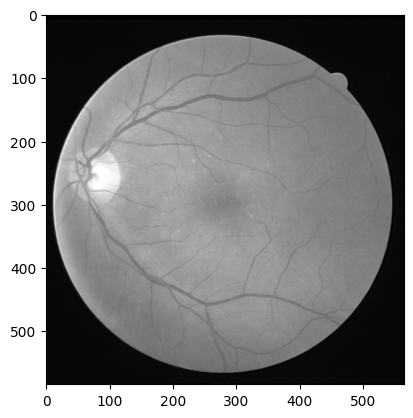

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_list[0][0],'gray')
print(img_list[0].min(), img_list[0].max())

In [ ]:
a = get_patch([img_list[0]], 500, 1000)
len(a)

4

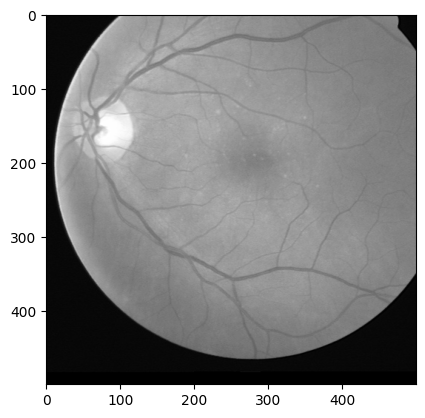

In [ ]:
plt.imshow(a[2][0],'gray')

In [ ]:
if mode == "training":
    img_patch = get_patch(img_list, patch_size, stride)
    gt_patch = get_patch(gt_list, patch_size, stride)
    save_patch(img_patch, save_path, "img_patch", name)
    save_patch(gt_patch, save_path, "gt_patch", name)
elif mode == "test":
    if name != "CHUAC":
        img_list = get_square(img_list, name)
        gt_list = get_square(gt_list, name)
    save_each_image(img_list, save_path, "img", name)
    save_each_image(gt_list, save_path, "gt", name)


20it [00:29,  1.47s/it]


save DRIVE img_patch : img_patch_0.pkl
save DRIVE img_patch : img_patch_1.pkl
save DRIVE img_patch : img_patch_2.pkl


KeyboardInterrupt: 

In [ ]:
a = img_list[0]

## my dataet

In [ ]:
a = np.array([[1,1,1],[2,2,2],[3,3,3]])
np.expand_dims(a,axis=0).shape

(1, 3, 3)

In [ ]:
# Utils

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], 0)
        image = image/255.0 ## (512, 512)
        image = np.expand_dims(image, axis=0) ## (1,512,512)
        # image = np.transpose(image, (2, 0, 1))  ## (1, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [ ]:
from glob import glob
import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 4
num_epochs = 150
lr = 1e-4

Dataset Size:
Train: 400 - Valid: 20



In [ ]:
""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
# valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# valid_loader = DataLoader(
#     dataset=valid_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=2
# )

device = torch.device('cuda')
model = model.to(device)


In [ ]:
next(iter(train_dataset))[0].shape

torch.Size([1, 512, 512])

In [ ]:
%ls datasets/DRIVE/training_pro/

In [ ]:
pickle.load("datasets/DRIVE/training_pro/img_patch_0.pkl", )

TypeError: load() takes exactly 1 positional argument (2 given)

In [ ]:
import matplotlib.pyplot as plt


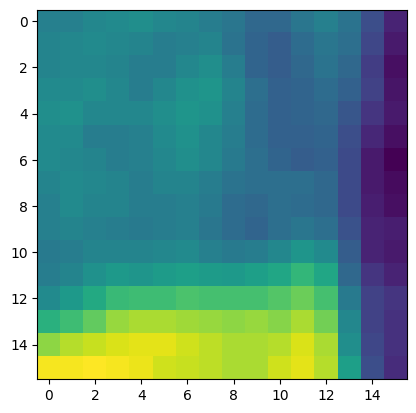

In [ ]:
plt.imshow(objects[0][0])

# Train

## Trainer

In [ ]:
%pip install ttach

In [ ]:
trainer.lr_scheduler.step()

TypeError: ReduceLROnPlateau.step() missing 1 required positional argument: 'metrics'

In [ ]:
import os
import time
from datetime import datetime
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils import tensorboard
from tqdm import tqdm
# from utils.helpers import dir_exists, get_instance, remove_files, double_threshold_iteration
# from utils.metrics import AverageMeter, get_metrics, get_metrics, count_connect_component
import ttach as tta


class Trainer:
    def __init__(self, model, CFG=None, loss=None, train_loader=None, val_loader=None):
        self.CFG = CFG
        if self.CFG['amp'] is True:
            self.scaler = torch.cuda.amp.GradScaler(enabled=True)
        self.loss = loss
        self.model = nn.DataParallel(model.cuda())
        self.train_loader = train_loader
        self.val_loader = val_loader
        # self.optimizer = get_instance(
        #     torch.optim, "optimizer", CFG, self.model.parameters())
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # self.lr_scheduler = get_instance(
        #     torch.optim.lr_scheduler, "lr_scheduler", CFG, self.optimizer)
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

        start_time = datetime.now().strftime('%y%m%d%H%M%S')
        self.checkpoint_dir = os.path.join(
            CFG['save_dir'], self.CFG['model']['type'], start_time)
        self.writer = tensorboard.SummaryWriter(self.checkpoint_dir)
        dir_exists(self.checkpoint_dir)
        cudnn.benchmark = True

    def train(self):
        for epoch in range(1, self.CFG['epochs'] + 1):
            self._train_epoch(epoch)
            if self.val_loader is not None and epoch % self.CFG['val_per_epochs'] == 0:
                results = self._valid_epoch(epoch)
                # logger.info(f'## Info for epoch {epoch} ## ')
                # for k, v in results.items():
                    # logger.info(f'{str(k):15s}: {v}')
            if epoch % self.CFG['save_period'] == 0:
                self._save_checkpoint(epoch)

    def _train_epoch(self, epoch):
        self.model.train()
        wrt_mode = 'train'
        self._reset_metrics()
        tbar = tqdm(self.train_loader, ncols=160)
        tic = time.time()
        for img, gt in tbar:
            self.data_time.update(time.time() - tic)
            img = img.cuda(non_blocking=True)
            gt = gt.cuda(non_blocking=True)
            self.optimizer.zero_grad()
            if self.CFG['amp'] is True:
                with torch.cuda.amp.autocast(enabled=True):
                    pre = self.model(img)
                    loss = self.loss(pre, gt)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                pre = self.model(img)
                loss = self.loss(pre, gt)
                loss.backward()
                self.optimizer.step()
            self.total_loss.update(loss.item())
            self.batch_time.update(time.time() - tic)

            self._metrics_update(
                *get_metrics(pre, gt, threshold=self.CFG['threshold']).values())
            tbar.set_description(
                'TRAIN ({}) | Loss: {:.4f} | AUC {:.4f} F1 {:.4f} Acc {:.4f}  Sen {:.4f} Spe {:.4f} Pre {:.4f} IOU {:.4f} |B {:.2f} D {:.2f} |'.format(
                    epoch, self.total_loss.average, *self._metrics_ave().values(), self.batch_time.average, self.data_time.average))
            tic = time.time()
        self.writer.add_scalar(
            f'{wrt_mode}/loss', self.total_loss.average, epoch)
        for k, v in list(self._metrics_ave().items())[:-1]:
            self.writer.add_scalar(f'{wrt_mode}/{k}', v, epoch)
        for i, opt_group in enumerate(self.optimizer.param_groups):
            self.writer.add_scalar(
                f'{wrt_mode}/Learning_rate_{i}', opt_group['lr'], epoch)
        # self.lr_scheduler.step()

    def _valid_epoch(self, epoch):
        # logger.info('\n###### EVALUATION ######')
        self.model.eval()
        wrt_mode = 'val'
        self._reset_metrics()
        tbar = tqdm(self.val_loader, ncols=160)
        with torch.no_grad():
            for img, gt in tbar:
                img = img.cuda(non_blocking=True)
                gt = gt.cuda(non_blocking=True)
                if self.CFG['amp'] is True:
                    with torch.cuda.amp.autocast(enabled=True):
                        predict = self.model(img)
                        loss = self.loss(predict, gt)
                else:
                    predict = self.model(img)
                    loss = self.loss(predict, gt)
                self.total_loss.update(loss.item())
                self._metrics_update(
                    *get_metrics(predict, gt, threshold=self.CFG['threshold']).values())
                tbar.set_description(
                    'EVAL ({})  | Loss: {:.4f} | AUC {:.4f} F1 {:.4f} Acc {:.4f} Sen {:.4f} Spe {:.4f} Pre {:.4f} IOU {:.4f} |'.format(
                        epoch, self.total_loss.average, *self._metrics_ave().values()))
                self.writer.add_scalar(
                    f'{wrt_mode}/loss', self.total_loss.average, epoch)

        self.writer.add_scalar(
            f'{wrt_mode}/loss', self.total_loss.average, epoch)
        for k, v in list(self._metrics_ave().items())[:-1]:
            self.writer.add_scalar(f'{wrt_mode}/{k}', v, epoch)
        log = {
            'val_loss': self.total_loss.average,
            **self._metrics_ave()
        }
        return log

    def _save_checkpoint(self, epoch):
        state = {
            'arch': type(self.model).__name__,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'config': self.CFG
        }
        filename = os.path.join(self.checkpoint_dir,
                                f'checkpoint-epoch{epoch}.pth')
        # logger.info(f'Saving a checkpoint: {filename} ...')
        torch.save(state, filename)
        return filename

    def _reset_metrics(self):
        self.batch_time = AverageMeter()
        self.data_time = AverageMeter()
        self.total_loss = AverageMeter()
        self.auc = AverageMeter()
        self.f1 = AverageMeter()
        self.acc = AverageMeter()
        self.sen = AverageMeter()
        self.spe = AverageMeter()
        self.pre = AverageMeter()
        self.iou = AverageMeter()
        self.CCC = AverageMeter()
    def _metrics_update(self, auc, f1, acc, sen, spe, pre, iou):
        self.auc.update(auc)
        self.f1.update(f1)
        self.acc.update(acc)
        self.sen.update(sen)
        self.spe.update(spe)
        self.pre.update(pre)
        self.iou.update(iou)

    def _metrics_ave(self):

        return {
            "AUC": self.auc.average,
            "F1": self.f1.average,
            "Acc": self.acc.average,
            "Sen": self.sen.average,
            "Spe": self.spe.average,
            "pre": self.pre.average,
            "IOU": self.iou.average
        }

## Train

In [ ]:
trainer = Trainer(
        model=model,
        loss=loss,
        CFG=CFG,
        train_loader=train_loader,
        val_loader=None
    )


trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|                                                                                                                                   | 0/100 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
TRAIN (1) | Loss: 0.3382 | AUC 0.9366 F1 0.6791 Acc 0.9407  Sen 0.6908 Spe 0.9659 Pre 0.6707 IOU 0.5151 |B 1.49 D 0.01 |: 100%|█| 100/100 [03:19<00:00,  1.97s/i/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely le

In [ ]:
# from bunch import Bunch
# from loguru import logger
# from ruamel.yaml import safe_load
from torch.utils.data import DataLoader
# import models
# from dataset import vessel_dataset
# from trainer import Trainer
# from utils import losses
# from utils.helpers import get_instance, seed_torch


def main(CFG, data_path, batch_size, with_val=False):
    seed_torch()
    if with_val:
        train_dataset = vessel_dataset(data_path, mode="training", split=0.9)
        val_dataset = vessel_dataset(
            data_path, mode="training", split=0.9, is_val=True)
        val_loader = DataLoader(
            val_dataset, batch_size, shuffle=False, num_workers=16, pin_memory=True, drop_last=False)
    else:
        train_dataset = vessel_dataset(data_path, mode="training")
    train_loader = DataLoader(
        train_dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

    # logger.info('The patch number of train is %d' % len(train_dataset))
    model = get_instance(models, 'model', CFG)
    # logger.info(f'\n{model}\n')
    loss = get_instance(losses, 'loss', CFG)
    trainer = Trainer(
        model=model,
        loss=loss,
        CFG=CFG,
        train_loader=train_loader,
        val_loader=val_loader if with_val else None
    )

    trainer.train()


BATCH_SIZE = 4
VAL = True


main(CFG, DATA_PATH, BATCH_SIZE, VAL)

# Test

In [ ]:
vessel_dataset("datasets/DRIVE/", mode="training", split=0.9)

KeyboardInterrupt: 